General Robust Regression Model Summary (with Sex as a factor and interaction terms):
                    Robust linear Model Regression Results                    
Dep. Variable:       percentage_taken   No. Observations:                  313
Model:                            RLM   Df Residuals:                      304
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 02 Oct 2024                                         
Time:                        21:56:42                                         
No. Iterations:                    27                                         
                                                                                                 coef    std err          z 

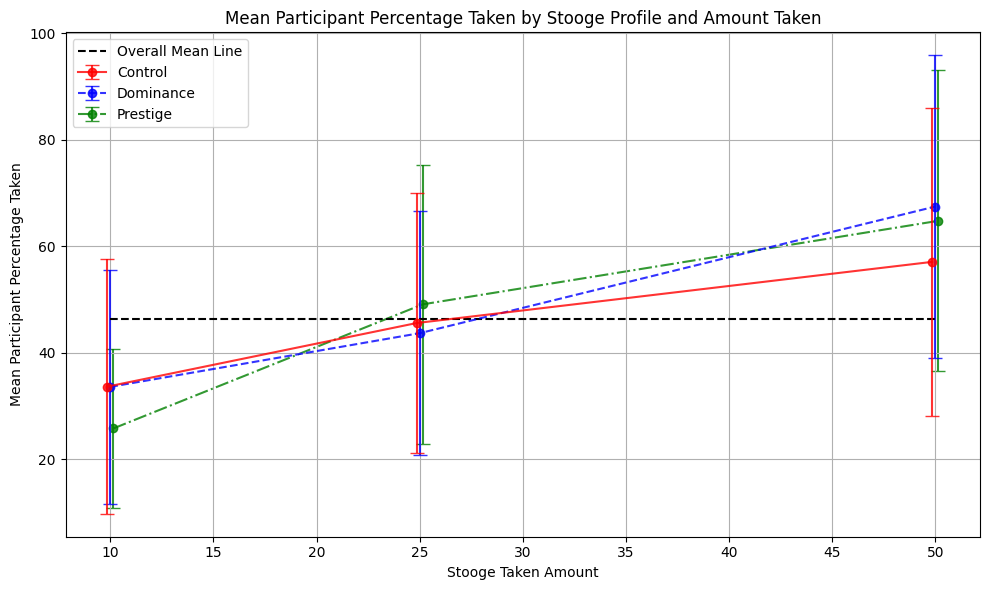

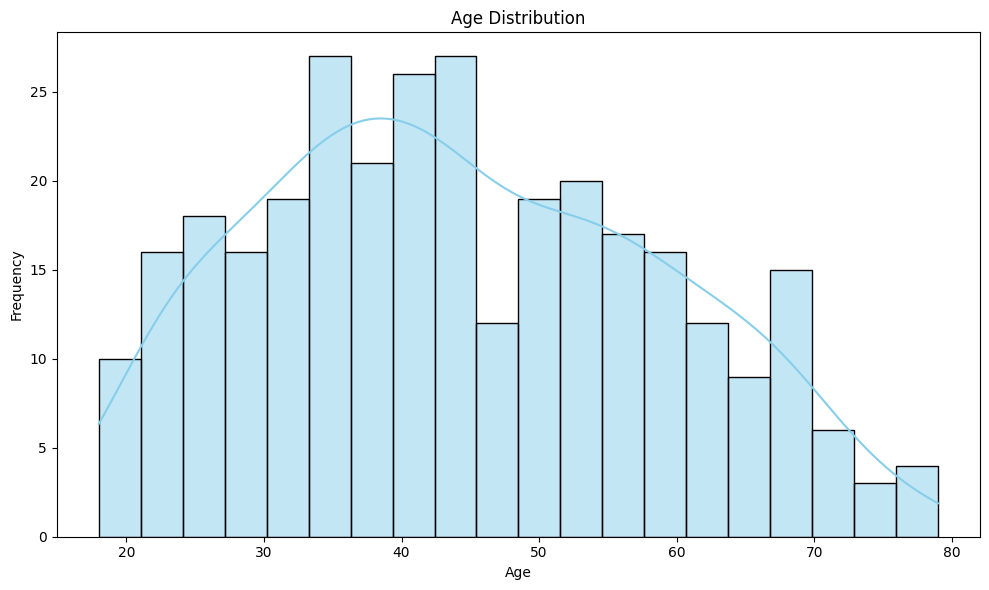

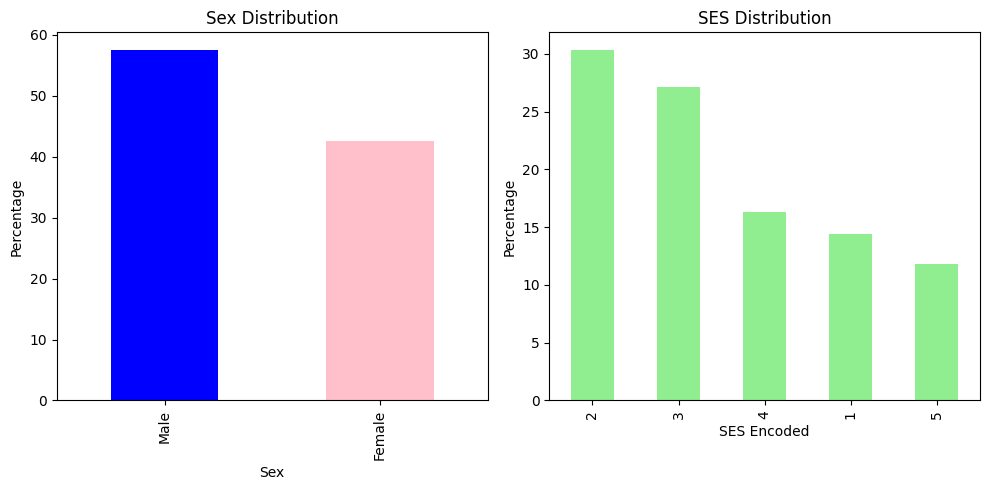

Required sample size for adequate power: 248.2088397056347
Achieved power with actual sample size: 0.8998147683615818


In [38]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.power import FTestAnovaPower

# Set up the working directory
os.chdir('/Users/aligiritlioglu/Desktop/code')

# Load the dataset
file_path = 'PhD Game_October 2, 2024_07.20.csv'
survey_data = pd.read_csv(file_path, delimiter=';', on_bad_lines='skip')

# Extract relevant columns for analysis
relevant_columns = survey_data[['stooge_profile', 'stooge_took', '_10', '_1', '_6', 'Age', 'Sex']].copy()

# Function to extract the numeric amount from the 'stooge_took' column
def extract_amount(text):
    if isinstance(text, str):  # Ensure the input is a string
        match = re.search(r'&pound;(\d+)', text)
        return int(match.group(1)) if match else None
    return None

relevant_columns['stooge_taken_amount'] = relevant_columns['stooge_took'].apply(extract_amount)

# Function to get the participant's choice
def get_participant_choice(row):
    for col in ['_10', '_1', '_6']:
        if pd.notna(row[col]):
            return row[col]
    return None

relevant_columns['participant_choice'] = relevant_columns.apply(get_participant_choice, axis=1)

# Creating a new DataFrame to avoid SettingWithCopyWarning
filtered_data = relevant_columns.dropna(subset=['participant_choice']).copy()

# Calculating the remaining amount and the participant's percentage taken
initial_pool_amount = 100
filtered_data['remaining_amount'] = initial_pool_amount - filtered_data['stooge_taken_amount']
filtered_data['participant_percentage_taken'] = (filtered_data['participant_choice'] / filtered_data['remaining_amount']) * 100

# Convert 'Age' to numeric and filter out ages below 18
survey_data['Age'] = pd.to_numeric(survey_data['Age'], errors='coerce')
survey_data = survey_data[survey_data['Age'] >= 18]

# Encode the SES column as ordinal
ses_encoding = {
    'Low SES: Less than £15,000': 1,
    'Lower-Middle SES: £15,000 to £30,000': 2,
    'Middle SES: £30,000 to £45,000': 3,
    'Upper-Middle SES: £45,000 to £60,000': 4,
    'High SES: More than £60,000': 5
}
survey_data['SES_encoded'] = survey_data['SES'].map(ses_encoding)

# Keep all stooge profiles, including 'neutral'
survey_data = survey_data[survey_data['stooge_profile'].isin(['dominance', 'prestige', 'neutral'])]

# Convert 'stooge_took' to a numeric column
survey_data['stooge_taken_amount'] = survey_data['stooge_took'].str.extract(r'&pound;(\d+)').astype(float)

# Get the participant's choice
survey_data['participant_choice'] = survey_data.apply(get_participant_choice, axis=1)

# Calculate the percentage of the remaining amount taken by the participant
survey_data['percentage_taken'] = (survey_data['participant_choice'] / (initial_pool_amount - survey_data['stooge_taken_amount'])) * 100

# Handle non-numeric values in the 'Age' column
survey_data['Age'] = survey_data['Age'].apply(lambda x: pd.to_numeric(x, errors='coerce', downcast='float'))

# Create 'stooge_state' as a new variable encoding 'neutral' as the baseline, followed by 'dominance' and 'prestige'
survey_data['stooge_state'] = pd.Categorical(survey_data['stooge_profile'], categories=['neutral', 'dominance', 'prestige'], ordered=True)

# Make 'stooge_taken_amount' ordinal with 25 as the baseline
survey_data['stooge_taken_amount_ordinal'] = pd.Categorical(survey_data['stooge_taken_amount'], categories=[10, 25, 50], ordered=True)

# General Robust Regression with Sex as a Factor and interaction terms using Huber's T norm
formula_general = 'percentage_taken ~ Sex + Age + SES_encoded + C(stooge_state) * C(stooge_taken_amount_ordinal, Treatment(reference=25))'
general_model = smf.rlm(formula=formula_general, data=survey_data, M=sm.robust.norms.HuberT()).fit()

print("General Robust Regression Model Summary (with Sex as a factor and interaction terms):")
print(general_model.summary())

# Separate Robust Regressions for Males and Females using Huber's T norm
survey_data_male = survey_data[survey_data['Sex'] == 'Male']
survey_data_female = survey_data[survey_data['Sex'] == 'Female']

# Regression for Males with interaction terms
formula_male = 'percentage_taken ~ Age + SES_encoded + C(stooge_state) * C(stooge_taken_amount_ordinal, Treatment(reference=25))'
model_male = smf.rlm(formula=formula_male, data=survey_data_male, M=sm.robust.norms.HuberT()).fit()

# Regression for Females with interaction terms
formula_female = 'percentage_taken ~ Age + SES_encoded + C(stooge_state) * C(stooge_taken_amount_ordinal, Treatment(reference=25))'
model_female = smf.rlm(formula=formula_female, data=survey_data_female, M=sm.robust.norms.HuberT()).fit()

print("\nMale Robust Regression Model Summary:")
print(model_male.summary())

print("\nFemale Robust Regression Model Summary:")
print(model_female.summary())

# Increase jitter and add capsize to error bars
jitter = 0.15  # Increase the jitter for clearer separation
capsize_value = 5  # Set cap size for error bars

# Plotting the means for each subgroup with larger jitter and error bar caps
plt.figure(figsize=(10, 6))

# Means and standard deviations for each stooge profile
means_dominance = filtered_data[filtered_data['stooge_profile'] == 'dominance'].groupby('stooge_taken_amount')['participant_percentage_taken'].mean()
std_dominance = filtered_data[filtered_data['stooge_profile'] == 'dominance'].groupby('stooge_taken_amount')['participant_percentage_taken'].std()

means_prestige = filtered_data[filtered_data['stooge_profile'] == 'prestige'].groupby('stooge_taken_amount')['participant_percentage_taken'].mean()
std_prestige = filtered_data[filtered_data['stooge_profile'] == 'prestige'].groupby('stooge_taken_amount')['participant_percentage_taken'].std()

means_control = filtered_data[filtered_data['stooge_profile'] == 'control'].groupby('stooge_taken_amount')['participant_percentage_taken'].mean()
std_control = filtered_data[filtered_data['stooge_profile'] == 'control'].groupby('stooge_taken_amount')['participant_percentage_taken'].std()

# Plot means and standard deviations for all profiles with larger jitter, transparency, and capsize
# Control (red)
plt.errorbar(means_control.index - jitter, means_control.values, yerr=std_control.values, fmt='o-', label='Control', color='red', alpha=0.8, zorder=3, capsize=capsize_value)

# Dominance (blue)
plt.errorbar(means_dominance.index, means_dominance.values, yerr=std_dominance.values, fmt='o--', label='Dominance', color='blue', alpha=0.8, zorder=2, capsize=capsize_value)

# Prestige (green)
plt.errorbar(means_prestige.index + jitter, means_prestige.values, yerr=std_prestige.values, fmt='o-.', label='Prestige', color='green', alpha=0.8, zorder=1, capsize=capsize_value)

# Control line (overall mean)
control_line = [filtered_data['participant_percentage_taken'].mean()] * len(means_dominance.index)
plt.plot(means_dominance.index, control_line, linestyle='--', color='black', label='Overall Mean Line')

# Plot settings
plt.xlabel('Stooge Taken Amount')
plt.ylabel('Mean Participant Percentage Taken')
plt.title('Mean Participant Percentage Taken by Stooge Profile and Amount Taken')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mean_participant_percentage_taken_with_larger_jitter.png')  # Save the plot
plt.show()

# Demographic Data: Age and SES as bar plots
demographics = survey_data[['Age', 'Sex', 'SES_encoded']]

# Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(demographics['Age'], kde=True, bins=20, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('age_distribution.png')  # Save the plot
plt.show()

# Bar plots for Sex and SES distribution
plt.figure(figsize=(10, 5))

# Sex distribution as percentages
plt.subplot(1, 2, 1)
sex_distribution = demographics['Sex'].value_counts(normalize=True) * 100
sex_distribution.plot(kind='bar', color=['blue', 'pink'])
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Percentage')

# SES distribution as percentages
plt.subplot(1, 2, 2)
ses_distribution = demographics['SES_encoded'].value_counts(normalize=True) * 100
ses_distribution.plot(kind='bar', color='lightgreen')
plt.title('SES Distribution')
plt.xlabel('SES Encoded')
plt.ylabel('Percentage')

plt.tight_layout()
plt.savefig('demographics_distribution_barplots.png')  # Save the plot
plt.show()

# Power Analysis
effect_size = 0.25  # Estimated effect size from similar studies
alpha = 0.05
power = 0.80
num_groups = 3  # Number of stooge profiles
num_conditions = 3  # Number of conditions per stooge profile

# Calculate required sample size using FTestAnovaPower
power_analysis = FTestAnovaPower()
required_sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=num_groups * num_conditions)
print(f"Required sample size for adequate power: {required_sample_size}")

# Given the actual sample size of 311 participants
actual_sample_size = 313
achieved_power = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, nobs=actual_sample_size, k_groups=num_groups * num_conditions)
print(f"Achieved power with actual sample size: {achieved_power}")

Robust Regression Model Summary
                    Robust linear Model Regression Results                    
Dep. Variable:       percentage_taken   No. Observations:                  311
Model:                            RLM   Df Residuals:                      302
Method:                          IRLS   Df Model:                            8
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Thu, 11 Jul 2024                                         
Time:                        17:04:02                                         
No. Iterations:                    36                                         
                                                                                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------

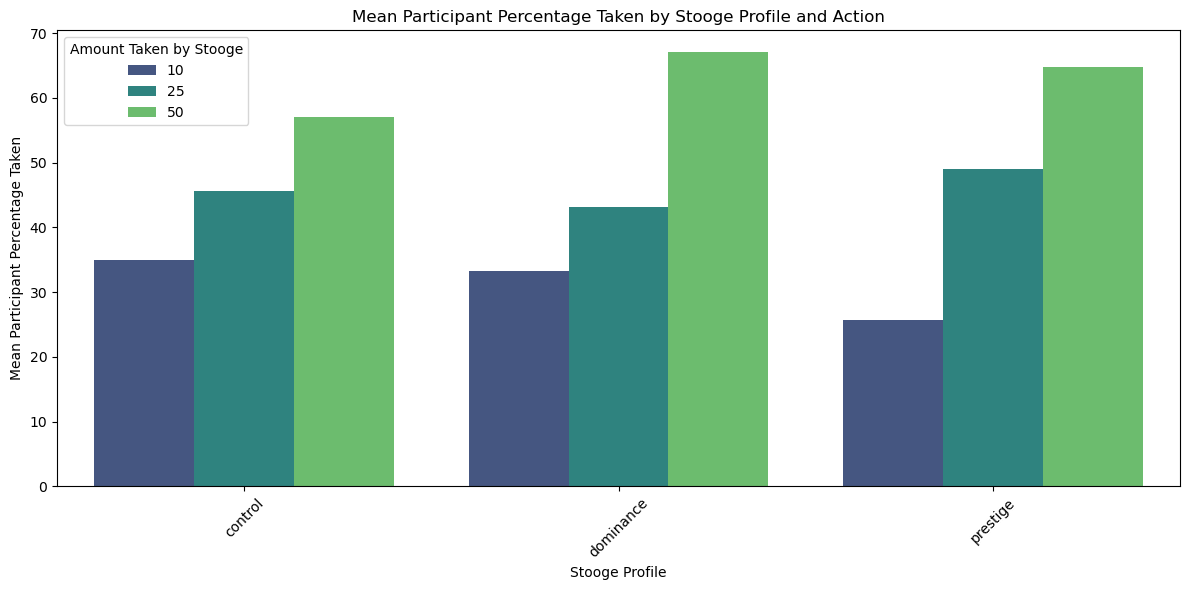


Checking group sizes and variance before Tukey's HSD test:
dominance    157
prestige     157
Name: stooge_profile, dtype: int64
Variance in dominance group: 771.3345199072799
Variance in prestige group: 775.7034375548177


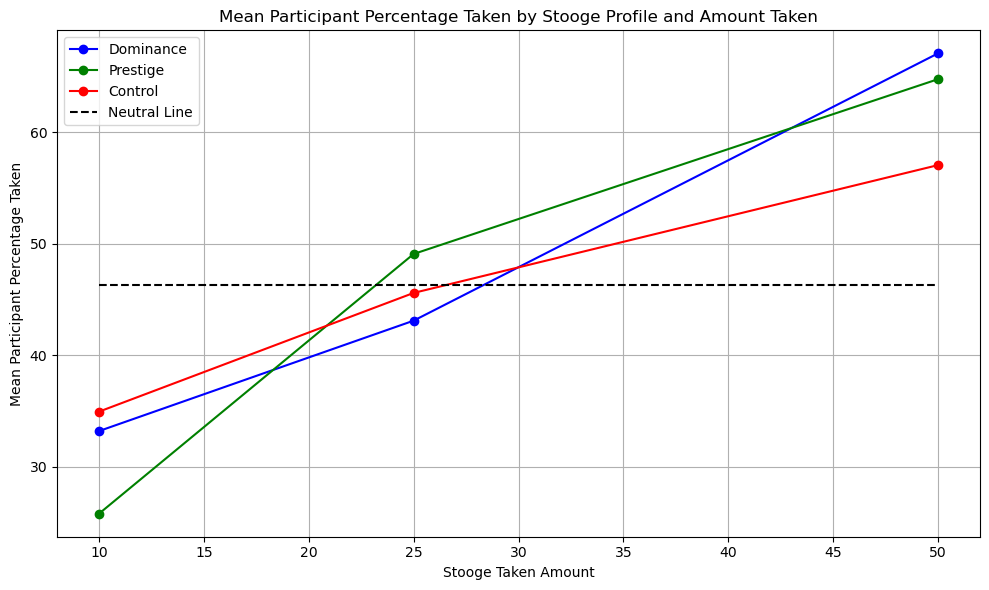

Age Summary Statistics:
count    314.000000
mean      44.127389
std       14.424077
min       18.000000
25%       33.000000
50%       43.000000
75%       55.000000
max       79.000000
Name: Age, dtype: float64

Sex Distribution (percentage):
Male      57.961783
Female    42.038217
Name: Sex, dtype: float64

SES Summary Statistics:
count    311.000000
mean       2.803859
std        1.219513
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: SES_encoded, dtype: float64


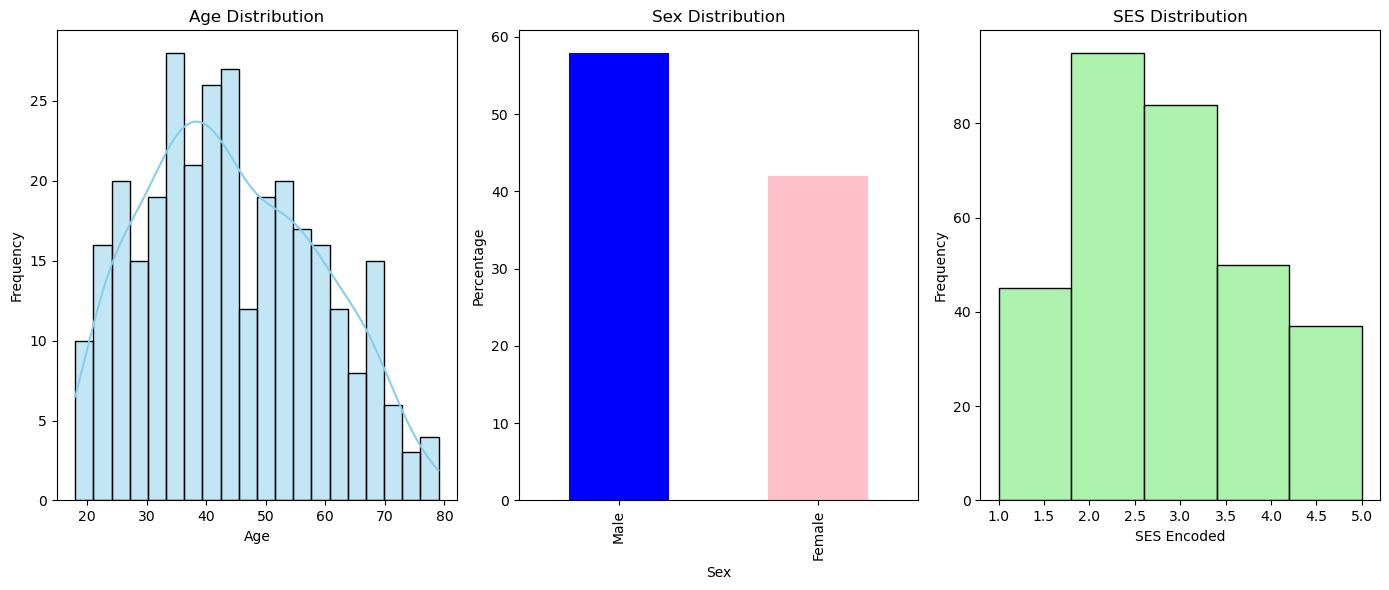

Required sample size for adequate power: 248.2088397056347
Achieved power with actual sample size: 0.8975259264926988


In [257]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.power import FTestAnovaPower

# Set up the API repository and working directory
from pydplace.api import Repos
api = Repos('/Users/aligiritlioglu/Desktop/code/')
os.chdir('/Users/aligiritlioglu/Desktop/code')

# Load the dataset
file_path = 'PhD Game_December 25, 2023_06.02.csv'  # Correct file path
survey_data = pd.read_csv(file_path, delimiter=';', on_bad_lines='skip')

# Extracting relevant columns for analysis
relevant_columns = survey_data[['stooge_profile', 'stooge_took', '_10', '_1', '_6', 'Age']].copy()

# Function to extract the numeric amount from the 'stooge_took' column
def extract_amount(text):
    match = re.search(r'&pound;(\d+)', text)
    return int(match.group(1)) if match else None

relevant_columns['stooge_taken_amount'] = relevant_columns['stooge_took'].apply(extract_amount)

# Function to get the participant's choice
def get_participant_choice(row):
    for col in ['_10', '_1', '_6']:
        if pd.notna(row[col]):
            return row[col]
    return None

relevant_columns['participant_choice'] = relevant_columns.apply(get_participant_choice, axis=1)

# Creating a new DataFrame to avoid SettingWithCopyWarning
filtered_data = relevant_columns.dropna(subset=['participant_choice']).copy()

# Calculating the remaining amount and the participant's percentage taken
initial_pool_amount = 100  # Adjust this value based on your initial pool amount
filtered_data['remaining_amount'] = initial_pool_amount - filtered_data['stooge_taken_amount']
filtered_data['participant_percentage_taken'] = (filtered_data['participant_choice'] / filtered_data['remaining_amount']) * 100

# Convert 'Age' to numeric and filter out ages below 18
survey_data['Age'] = pd.to_numeric(survey_data['Age'], errors='coerce')
survey_data = survey_data[survey_data['Age'] >= 18]

# Encode the SES column as ordinal
ses_encoding = {
    'Low SES: Less than £15,000': 1,
    'Lower-Middle SES: £15,000 to £30,000': 2,
    'Middle SES: £30,000 to £45,000': 3,
    'Upper-Middle SES: £45,000 to £60,000': 4,
    'High SES: More than £60,000': 5
}
survey_data['SES_encoded'] = survey_data['SES'].map(ses_encoding)

# Keep only the rows with 'dominance' and 'prestige' profiles
survey_data = survey_data[survey_data['stooge_profile'].isin(['dominance', 'prestige'])]

# Convert 'stooge_took' to a numeric column
survey_data['stooge_taken_amount'] = survey_data['stooge_took'].str.extract(r'&pound;(\d+)').astype(float)

# Get the participant's choice
survey_data['participant_choice'] = survey_data.apply(get_participant_choice, axis=1)

# Calculate the percentage of the remaining amount taken by the participant
survey_data['percentage_taken'] = (survey_data['participant_choice'] / (initial_pool_amount - survey_data['stooge_taken_amount'])) * 100

# Handle non-numeric values in the 'Age' column (replace NaN with -1)
survey_data['Age'] = survey_data['Age'].apply(lambda x: pd.to_numeric(x, errors='coerce', downcast='float'))

# Convert Age to a continuous variable
survey_data['Age'] = survey_data['Age'].astype(float)

# Create 'stooge_state' as a new variable encoding 'dominance' as 0 and 'prestige' as 1, with control as the baseline
survey_data['stooge_state'] = pd.Categorical(survey_data['stooge_profile'], categories=['control', 'dominance', 'prestige'], ordered=True)

# Make 'stooge_taken_amount' ordinal with 25 as the baseline
survey_data['stooge_taken_amount_ordinal'] = pd.Categorical(survey_data['stooge_taken_amount'], categories=[10, 25, 50], ordered=True)

# Function to calculate rounded bias
def calculate_rounded_bias(row):
    nearest_rounded = min([0, 0.25, 0.5, 0.75, 1], key=lambda x: abs(x-row['percentage_taken']))
    distance = abs(row['percentage_taken'] - nearest_rounded)
    return distance

# Apply the function to create a new column in the DataFrame
survey_data['rounded_bias_continuous'] = survey_data.apply(calculate_rounded_bias, axis=1)

# Define the regression formula including interaction terms and treating SES as ordinal
formula = 'percentage_taken ~ Sex + Age + SES_encoded + C(stooge_state) + C(stooge_taken_amount_ordinal, Treatment(reference=25)) + C(stooge_state):C(stooge_taken_amount_ordinal, Treatment(reference=25))'

# Fit the robust regression model using Huber's T norm
robust_model = smf.rlm(formula, data=survey_data, M=sm.robust.norms.HuberT()).fit()

# Print the summary of the robust regression model
print("Robust Regression Model Summary")
print(robust_model.summary())

# Constructing the multiple linear regression summary table
summary = robust_model.summary2().tables[1]
summary.reset_index(inplace=True)
summary.columns = ['Predictor', 'B', 'SE B', 't', 'p', 'Conf. Int. Low', 'Conf. Int. High']

# Display the regression summary in the requested format
formatted_summary = summary[['Predictor', 'B', 'SE B', 't', 'p']]
formatted_summary.columns = ['Predictor', 'B', 'SE B', 't', 'p']

# Display the final formatted summary
print("Formatted Regression Summary")
print(formatted_summary)

# Save the formatted summary to a CSV file for easy viewing
formatted_summary.to_csv('formatted_summary.csv', index=False)

# Calculating the mean percentage values for each combination of stooge profile and stooge action
grouped_data = filtered_data.groupby(['stooge_profile', 'stooge_taken_amount'])
mean_percentage_by_combination = grouped_data['participant_percentage_taken'].mean().reset_index()
mean_percentage_by_combination.columns = ['Stooge Profile', 'Amount Taken by Stooge', 'Mean Participant Percentage Taken']

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=mean_percentage_by_combination,
    x='Stooge Profile',
    y='Mean Participant Percentage Taken',
    hue='Amount Taken by Stooge',
    palette='viridis',
)
plt.title('Mean Participant Percentage Taken by Stooge Profile and Action')
plt.xlabel('Stooge Profile')
plt.ylabel('Mean Participant Percentage Taken')
plt.xticks(rotation=45)
plt.legend(title='Amount Taken by Stooge')
plt.tight_layout()
plt.savefig('amount_taken_by_stooge.png')  # Save the plot
plt.show()

# Check group sizes and variance
print("\nChecking group sizes and variance before Tukey's HSD test:")
group_sizes = survey_data['stooge_profile'].value_counts()
print(group_sizes)

# Verify variance within groups
for group in survey_data['stooge_profile'].unique():
    variance = survey_data[survey_data['stooge_profile'] == group]['percentage_taken'].var()
    print(f"Variance in {group} group: {variance}")

# Plotting the means for each subgroup including the neutral line
plt.figure(figsize=(10, 6))

# Separate means for each stooge profile
means_dominance = filtered_data[filtered_data['stooge_profile'] == 'dominance'].groupby('stooge_taken_amount')['participant_percentage_taken'].mean()
means_prestige = filtered_data[filtered_data['stooge_profile'] == 'prestige'].groupby('stooge_taken_amount')['participant_percentage_taken'].mean()
means_control = filtered_data[filtered_data['stooge_profile'] == 'control'].groupby('stooge_taken_amount')['participant_percentage_taken'].mean()

plt.plot(means_dominance.index, means_dominance.values, marker='o', linestyle='-', color='blue', label='Dominance')
plt.plot(means_prestige.index, means_prestige.values, marker='o', linestyle='-', color='green', label='Prestige')
plt.plot(means_control.index, means_control.values, marker='o', linestyle='-', color='red', label='Control')

# Plot the neutral line
neutral_line = [filtered_data['participant_percentage_taken'].mean()] * len(means_dominance.index)
plt.plot(means_dominance.index, neutral_line, linestyle='--', color='black', label='Neutral Line')

# Plot settings
plt.xlabel('Stooge Taken Amount')
plt.ylabel('Mean Participant Percentage Taken')
plt.title('Mean Participant Percentage Taken by Stooge Profile and Amount Taken')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('mean_participant_percentage_taken_with_neutral_line.png')  # Save the plot
plt.show()

# Get demographic information for the participants
demographics = survey_data[['Age', 'Sex', 'SES_encoded']]

# Calculating summary statistics for Age
age_summary = demographics['Age'].describe()

# Calculating the distribution of Sex as a percentage
sex_distribution = demographics['Sex'].value_counts(normalize=True) * 100

# Calculating summary statistics for SES
ses_summary = demographics['SES_encoded'].describe()

# Display the results
print("Age Summary Statistics:")
print(age_summary)
print("\nSex Distribution (percentage):")
print(sex_distribution)
print("\nSES Summary Statistics:")
print(ses_summary)

# Plotting the demographic information
plt.figure(figsize=(14, 6))

# Age distribution
plt.subplot(1, 3, 1)
sns.histplot(demographics['Age'], kde=True, bins=20, color='skyblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Sex distribution
plt.subplot(1, 3, 2)
sex_distribution.plot(kind='bar', color=['blue', 'pink'])
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Percentage')

# SES distribution
plt.subplot(1, 3, 3)
sns.histplot(demographics['SES_encoded'], bins=5, kde=False, color='lightgreen')
plt.title('SES Distribution')
plt.xlabel('SES Encoded')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('demographics_distribution.png')  # Save the plot
plt.show()

# Power Analysis
effect_size = 0.25  # Estimated effect size from similar studies
alpha = 0.05
power = 0.80
num_groups = 3  # Number of stooge profiles
num_conditions = 3  # Number of conditions per stooge profile

# Calculate the required sample size using FTestAnovaPower
power_analysis = FTestAnovaPower()
required_sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, k_groups=num_groups * num_conditions)
print(f"Required sample size for adequate power: {required_sample_size}")

# Given the actual sample size of 311 participants
actual_sample_size = 311
achieved_power = power_analysis.solve_power(effect_size=effect_size, alpha=alpha, nobs=actual_sample_size, k_groups=num_groups * num_conditions)
print(f"Achieved power with actual sample size: {achieved_power}")

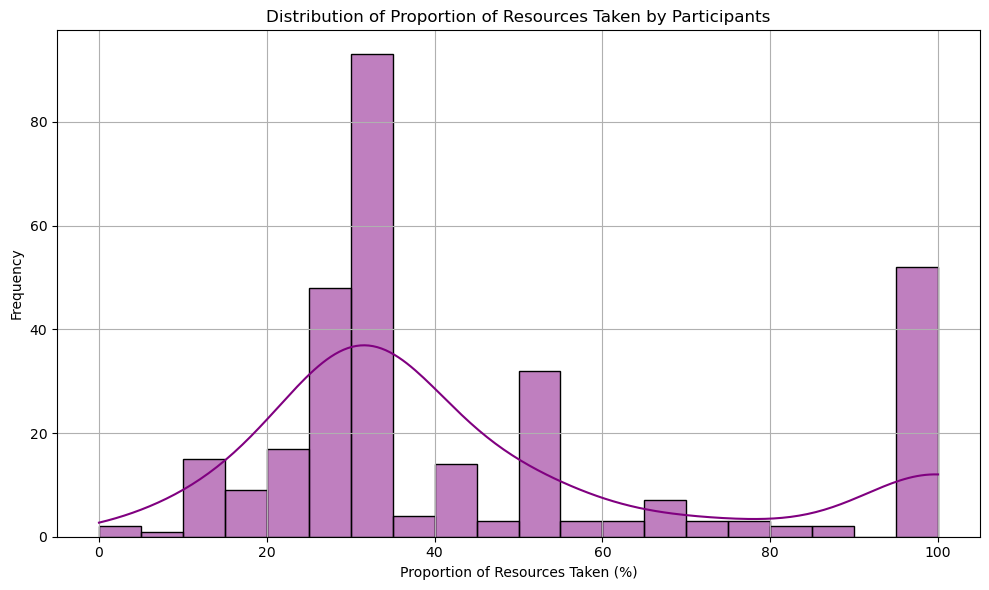

In [258]:
# Plotting the histogram of the distribution of the proportion of resources taken by the participants
plt.figure(figsize=(10, 6))
sns.histplot(survey_data['percentage_taken'], bins=20, kde=True, color='purple')
plt.title('Distribution of Proportion of Resources Taken by Participants')
plt.xlabel('Proportion of Resources Taken (%)')
plt.ylabel('Frequency')
plt.grid(True)

# Save the plot
plt.tight_layout()
plt.savefig('proportion_resources_taken_distribution.png')  # Save the figure
plt.show()

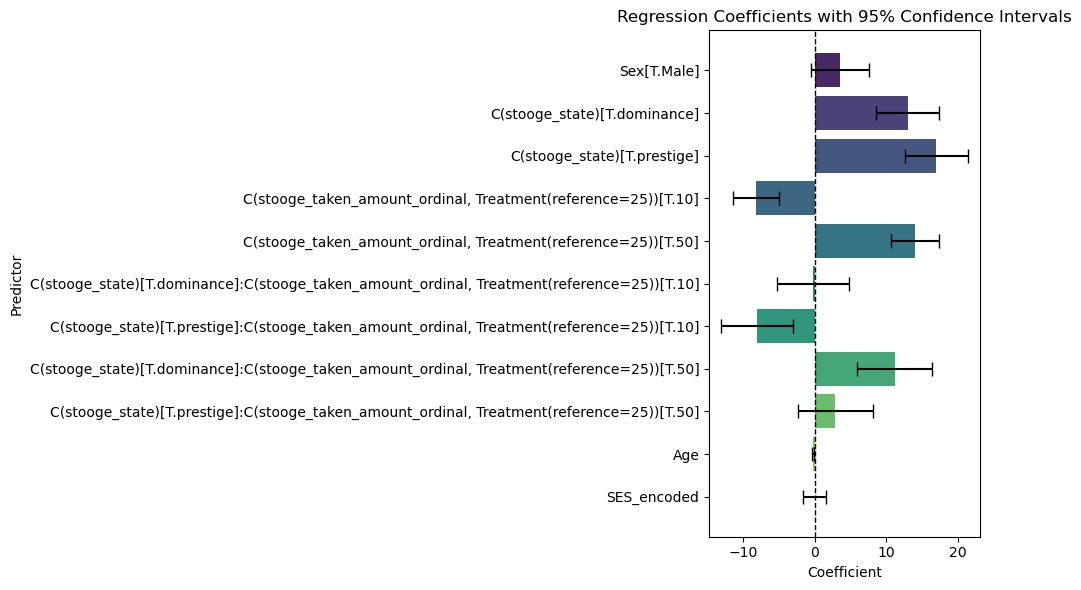

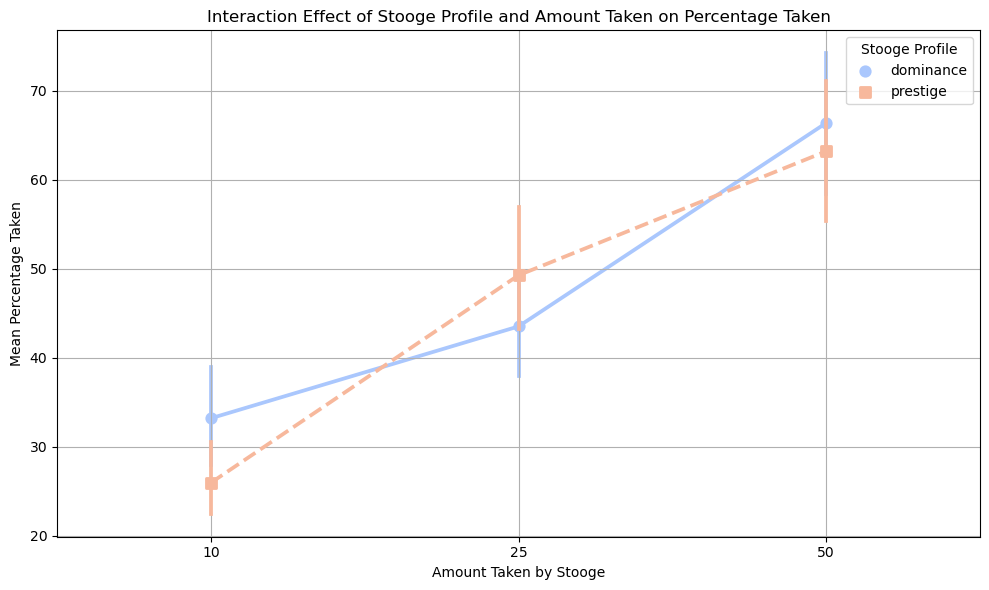

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Coefficient Plot (excluding intercept for clarity)
coefficients = robust_model.params.drop('Intercept')
conf_int = robust_model.conf_int().drop('Intercept')
coefficients_df = pd.DataFrame({
    'Coefficient': coefficients.values,
    'Predictor': coefficients.index,
    'Conf. Int. Low': conf_int[0],
    'Conf. Int. High': conf_int[1]
})

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Predictor', data=coefficients_df, palette='viridis')
plt.errorbar(coefficients_df['Coefficient'], coefficients_df['Predictor'], 
             xerr=[coefficients_df['Coefficient'] - coefficients_df['Conf. Int. Low'], 
                   coefficients_df['Conf. Int. High'] - coefficients_df['Coefficient']], 
             fmt='none', c='black', capsize=5)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.title('Regression Coefficients with 95% Confidence Intervals')
plt.xlabel('Coefficient')
plt.ylabel('Predictor')

# Save the coefficient plot
plt.tight_layout()
plt.savefig('coefficient_plot.png')  # Save the coefficient plot
plt.show()

# 2. Interaction Effects Plot: Stooge Profile * Amount Taken
plt.figure(figsize=(10, 6))
sns.pointplot(x='stooge_taken_amount_ordinal', y='percentage_taken', hue='stooge_profile', 
              data=survey_data, palette='coolwarm', markers=['o', 's', 'D'], linestyles=['-', '--', '-.'])
plt.title('Interaction Effect of Stooge Profile and Amount Taken on Percentage Taken')
plt.xlabel('Amount Taken by Stooge')
plt.ylabel('Mean Percentage Taken')
plt.legend(title='Stooge Profile')
plt.grid(True)

# Save the interaction effects plot
plt.tight_layout()
plt.savefig('interaction_effects_plot.png')  # Save the interaction effects plot
plt.show()